In [30]:
import json
import mmcv
import pickle
from scipy import stats
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd

**Helper functions**

In [31]:
# Open json annotation
def open_json(path2file):
    with open(path2file, "rb") as handle:
        file = json.load(handle)
    return file


# Get unique ape IDs from file
def get_ape_ids(annotation):
    ids = list()
    frames = annotation["annotations"]
    for f in frames:
        for d in f["detections"]:
            ids.append(d["ape_id"])
    return list(set(ids))


# Flatten detections
def get_flat_df(annotation):
    video = annotation["video"]
    new_detections = []
    for frame in annotation["annotations"]:
        frame_idx = frame["frame_id"]
        for d in frame["detections"]:
            new_d = d
            new_d["frame_idx"] = frame_idx
            new_d["video"] = video
            new_detections.append(new_d)
    return pd.DataFrame(new_detections)


# Assign groups to detections for each ape
def assign_groups(per_ape_df):
    """
    Required to assign group to instances where the frames are
    consectutive but behaviours change.
    """

    frame_idxs = per_ape_df.frame_idx.to_list()
    behaviours = per_ape_df.behaviour.to_list()

    assert len(frame_idxs) == len(behaviours)

    # always begin groupings from 0
    group = 0
    groups = []

    for i in range(len(frame_idxs) - 1):
        # Check if frames are consecutive
        if (frame_idxs[i + 1] == frame_idxs[i] + 1) and (
            behaviours[i + 1] == behaviours[i]
        ):
            groups.append(group)
        else:
            groups.append(group)
            group += 1

    # Handle last frame
    if (frame_idxs[-1] == frame_idxs[-2] + 1) and (behaviours[-1] == behaviours[-2]):
        groups.append(group)
    else:
        group += 1
        groups.append(group)

    per_ape_df["group"] = groups
    return per_ape_df


def store_groups(flat_df, ape_ids):
    store = list()
    # for a single ape
    for ape_id in ape_ids:
        # filter by specific ape id
        video = flat_df.video.unique()[0]
        per_ape_df = flat_df[flat_df.ape_id == ape_id].sort_values(by="frame_idx")
        per_ape_df = assign_groups(per_ape_df)
        for g in per_ape_df.group.unique():
            index = per_ape_df[per_ape_df.group == g].behaviour.value_counts().index[0]
            value = per_ape_df[per_ape_df.group == g].behaviour.value_counts().values[0]
            info = dict(behaviour=index, frame_count=value, ape_id=ape_id, video=video)
            store.append(info)
    return store

**FPS for all PanAf500 videos**

In [32]:
fps = []
video_file_paths = glob("videos/raw/all/**/*.mp4", recursive=True)
for video_file_path in tqdm(video_file_paths):
    video = mmcv.VideoReader(video_file_path)
    fps.append(video.fps)
print(f"Mean FPS: {np.array(fps).mean()}")
print(f"STD FPS: {np.array(fps).std()}")

100%|██████████| 500/500 [00:06<00:00, 79.62it/s]

Mean FPS: 24.0
STD FPS: 0.0


**Video Resolutions**

In [33]:
names, widths, heights = [], [], []
video_file_paths = glob("videos/raw/all/**/*.mp4", recursive=True)
for video_file_path in tqdm(video_file_paths):
    video = mmcv.VideoReader(video_file_path)
    width, height = video.width, video.height
    video_name = video_file_path.split("/")[-1].split(".")[0]
    names.append(video_name)
    widths.append(width)
    heights.append(height)

100%|██████████| 500/500 [00:05<00:00, 88.45it/s]


In [34]:
resolution_df = pd.DataFrame({"name": names, "width": widths, "height": heights})

In [35]:
resolution_df

,name,width,height
0,aaJN6ZZbPh,720,404
1,DPw52gwsl1,720,404
2,JkF4v2WLfX,960,540
3,TsFCsskzig,720,404
4,D5D1IoY7jA,720,404
...,...,...,...
495,DvK4T8ZJIr,720,404
496,fTsHMGBZk4,720,404
497,0hu96Jv2As,720,404
498,hDJ8vi3TJM,720,404


**How long is each action performed?**

In [36]:
file_paths = glob("annotations/standard/json/obfu/all/**/*.json", recursive=True)

main_store = []
for fp in tqdm(file_paths):
    file = open_json(fp)
    ape_ids = get_ape_ids(file)
    flat_df = get_flat_df(file)
    store = store_groups(flat_df, ape_ids)
    main_store = main_store + store
df = pd.DataFrame(main_store)

  1%|          | 5/500 [00:00<00:09, 49.92it/s]

100%|██████████| 500/500 [00:06<00:00, 77.36it/s]


In [37]:
file_paths = glob("annotations/standard/json/obfu/all/**/*.json", recursive=True)

main_df = None
for i, fp in enumerate(tqdm(file_paths)):
    file = open_json(fp)
    ape_ids = get_ape_ids(file)
    flat_df = get_flat_df(file)
    if i == 0:
        main_df = flat_df
    else:
        main_df = pd.concat([main_df, flat_df])

100%|██████████| 500/500 [00:09<00:00, 54.66it/s] 


In [38]:
main_df = main_df.join(resolution_df.set_index("name"), on="video")

##### **Count apes per frame**

In [39]:
# Add column called frame which increments from 0 to the number of rows in the dataframe
# main_df['frame'] = range(len(main_df))

In [40]:
frame_count = list()
for v in main_df.video.unique():
    frame_count.extend(
        main_df[main_df.video == v]
        .groupby(by="frame_idx")["ape_id"]
        .apply(lambda x: 0 if x.unique() is None else len(x.unique()))
        .values
    )
frame_df = pd.DataFrame(frame_count, columns=["ape_count"])

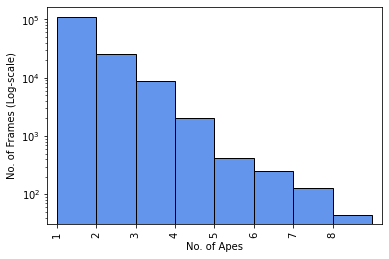

In [56]:
frame_df["frames"] = range(len(frame_df))
ax = (
    frame_df.groupby(by="ape_count")["frames"]
    .count()
    .plot(
        kind="bar",
        xlabel="No. of Apes",
        ylabel="No. of Frames (Log-scale)",
        align="edge",
        color="cornflowerblue",
        edgecolor="black",
        logy=True,
        width=1.0,
    )
)

ax.figure.savefig("p500_apes_per_frame.pdf", dpi=300, bbox_inches="tight")

In [42]:
frame_df.groupby(by="ape_count")["frames"].count()

ape_count
1    110765
2     25611
3      8829
4      2023
5       414
6       254
7       130
8        45
Name: frames, dtype: int64

##### **Count apes per video**

In [43]:
videos = df.groupby(by="video")["ape_id"].apply(lambda x: len(x.unique())).index
values = df.groupby(by="video")["ape_id"].apply(lambda x: len(x.unique())).values
count_df = pd.DataFrame({"video": videos, "ape_count": values})

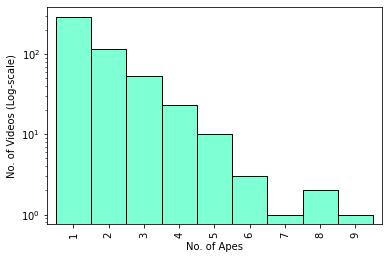

In [64]:
ax = (
    count_df.groupby(by="ape_count")["video"]
    .count()
    .plot(
        kind="bar",
        xlabel="No. of Apes",
        ylabel="No. of Videos (Log-scale)",
        color="aquamarine",
        edgecolor="black",
        logy=True,
        width=1.0,
    )
)

ax.figure.savefig("p500_apes_per_video.pdf", dpi=300, bbox_inches="tight")

In [62]:
count_df[count_df["ape_count"] == 8]

,video,ape_count
176,MnYV3cYzBq,8
407,pbMMPocj0m,8


**Calulate area of bounding box & proportion of whole image**

In [45]:
def calc_area(x):
    # Calculate the width and height of the bounding box
    x1, y1, x2, y2 = x
    width = x2 - x1
    height = y2 - y1

    # Calculate the area
    area = width * height
    return area


main_df["area"] = main_df["bbox"].apply(lambda x: calc_area(x))
main_df["image_area"] = (
    main_df["height"] * main_df["width"]
)  # Amend for actual per image resolution
main_df["area_ratio"] = (main_df["area"] / main_df["image_area"]) * 100
main_df["size_cat"] = main_df.area.apply(
    lambda x: "small"
    if x <= 32**2
    else "medium"
    if x <= 96**2 and x > 32**2
    else "large"
)

<AxesSubplot:>

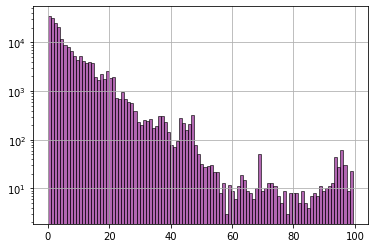

In [46]:
main_df["area_ratio"].hist(
    bins=100, color="purple", edgecolor="black", alpha=0.6, log=True, label="size_cat"
)
# Add set of images showing examples of small -> large bounding boxes

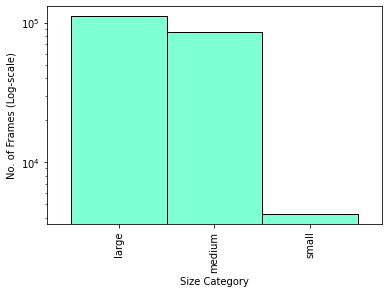

In [53]:
ax = (
    main_df.groupby(by="size_cat")["bbox"]
    .count()
    .plot(
        kind="bar",
        xlabel="Size Category",
        ylabel="No. of Frames (Log-scale)",
        color="aquamarine",
        edgecolor="black",
        logy=True,
        width=1.0,
    )
)

ax.figure.savefig("p500_small_medium_large.pdf", dpi=300, bbox_inches="tight")

In [19]:
main_df.size_cat.value_counts(), main_df.size_cat.value_counts() / len(
    main_df
), main_df.size_cat.value_counts().sum()

(large     111286
 medium     85899
 small       4245
 Name: size_cat, dtype: int64,
 large     0.552480
 medium    0.426446
 small     0.021074
 Name: size_cat, dtype: float64,
 201430)

**Per frame behaviour counts**

/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:568: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


<AxesSubplot:>

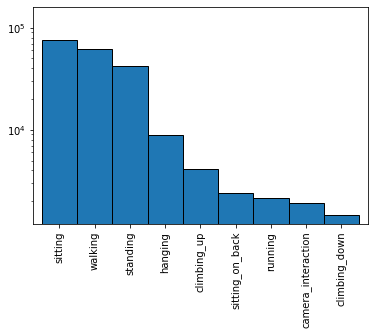

In [20]:
main_df.behaviour.value_counts().plot(
    kind="bar", logy=True, edgecolor="black", width=1.0, ylim=(0, 11**5)
)

In [21]:
main_df.behaviour.value_counts()

sitting               76117
walking               62515
standing              41934
hanging                8814
climbing_up            4098
sitting_on_back        2430
running                2128
camera_interaction     1939
climbing_down          1455
Name: behaviour, dtype: int64

**Total number of instances for each behaviour**

In [22]:
df.behaviour.value_counts()

walking               747
standing              366
sitting               308
climbing_up            81
hanging                50
climbing_down          35
running                34
camera_interaction     32
sitting_on_back        26
Name: behaviour, dtype: int64

**Average duration (and std) of each behaviour/activity**

In [23]:
action, seconds, std, frames, frames_std = [], [], [], [], []
for behaviour in df.behaviour.value_counts().index:
    action.append(behaviour)
    seconds.append(
        df[df.behaviour == behaviour]["frame_count"].mean() / np.array(fps).mean()
    )
    std.append(
        df[df.behaviour == behaviour]["frame_count"].std() / np.array(fps).mean()
    )

    frames.append(df[df.behaviour == behaviour]["frame_count"].sum())
    frames_std.append(df[df.behaviour == behaviour]["frame_count"].std())

duration_df = pd.DataFrame(
    dict(
        action=action,
        instances=df.behaviour.value_counts().values,
        seconds=seconds,
        seconds_std=std,
        frames=frames,
        frames_std=frames_std,
    )
)
duration_df

,action,instances,seconds,seconds_std,frames,frames_std
0,walking,747,3.487004,2.940185,62515,70.564445
1,standing,366,4.773907,4.591186,41934,110.188475
2,sitting,308,10.297213,5.514578,76117,132.349866
3,climbing_up,81,2.108025,1.671539,4098,40.116947
4,hanging,50,7.345000,5.235951,8814,125.662821
5,climbing_down,35,1.732143,1.244198,1455,29.860741
6,running,34,2.607843,2.063112,2128,49.514686
7,camera_interaction,32,2.524740,3.774470,1939,90.587281
8,sitting_on_back,26,3.894231,4.040614,2430,96.974731


In [24]:
for behaviour in df.behaviour.value_counts().index:
    print(
        behaviour,
        df[df.behaviour == behaviour]["frame_count"].std() / np.array(fps).mean(),
    )

walking 2.940185213848922
standing 4.591186458263594
sitting 5.514577762270317
climbing_up 1.6715394624066509
hanging 5.235950859767086
climbing_down 1.2441975503717542
running 2.06311190410438
camera_interaction 3.774470033519695
sitting_on_back 4.040613793603619


##### **Behaviour Distribution per Threshold**

In [4]:
import torch
from torchvision import transforms
from panaf.datasets import SupervisedPanAf
from torchvision.transforms.v2 import (
    ToTensor,
    Resize,
    ConvertDtype,
    Normalize,
    TrivialAugmentWide,
)

spatial_train_transform = transforms.Compose(
    [
        ToTensor(),
        Resize((224, 224)),
        TrivialAugmentWide(),
        ConvertDtype(dtype=torch.float32),
        Normalize(mean=[0.5017, 0.5159, 0.5168], std=[0.2814, 0.2778, 0.2635]),
    ]
)
spatial_test_transform = transforms.Compose(
    [
        ToTensor(),
        Resize((224, 224)),
        ConvertDtype(dtype=torch.float32),
        Normalize(mean=[0.5017, 0.5159, 0.5168], std=[0.2814, 0.2778, 0.2635]),
    ]
)
temporal_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

data_dir = "/home/dl18206/Desktop/phd/data/panaf/PanAf500/videos/raw/train"
ann_dir = (
    "/home/dl18206/Desktop/phd/data/panaf/PanAf500/annotations/standard/json/obfu/train"
)
dense_dir = "/home/dl18206/Desktop/phd/data/panaf/obfuscated/restructure/annotations/dense/train"
flow_dir = "/home/dl18206/Desktop/phd/data/panaf/obfuscated/frames"

threshold_dict = {}
train_thresholds = [16, 32, 64, 128]
print("Initialising thresholds...")

for threshold in train_thresholds:
    dataset = SupervisedPanAf(
        data_dir=data_dir,
        ann_dir=ann_dir,
        dense_dir=dense_dir,
        flow_dir=flow_dir,
        sequence_len=16,
        sample_itvl=1,
        stride=16,
        type="r",
        spatial_transform=spatial_train_transform,
        temporal_transform=temporal_transform,
        behaviour_threshold=threshold,
    )

    threshold_dict[f"t{threshold}"] = dict(
        sorted(dataset.samples_by_class.items(), key=lambda item: item[1], reverse=True)
    )

sample_itvl_dict = {}
sample_itvls = [1, 2, 3, 4]
print("Initialising itvls...")

for itvl in sample_itvls:
    dataset = SupervisedPanAf(
        data_dir=data_dir,
        ann_dir=ann_dir,
        dense_dir=dense_dir,
        flow_dir=flow_dir,
        sequence_len=16,
        sample_itvl=itvl,
        stride=16 * itvl,
        type="r",
        spatial_transform=spatial_train_transform,
        temporal_transform=temporal_transform,
        behaviour_threshold=16 * itvl,
    )

    sample_itvl_dict[f"s{itvl}"] = dict(
        sorted(dataset.samples_by_class.items(), key=lambda item: item[1], reverse=True)
    )

/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

Initialising thresholds...


100%|██████████| 400/400 [00:12<00:00, 31.93it/s]


Initialising itvls...


100%|██████████| 400/400 [00:12<00:00, 32.45it/s]


<AxesSubplot:>

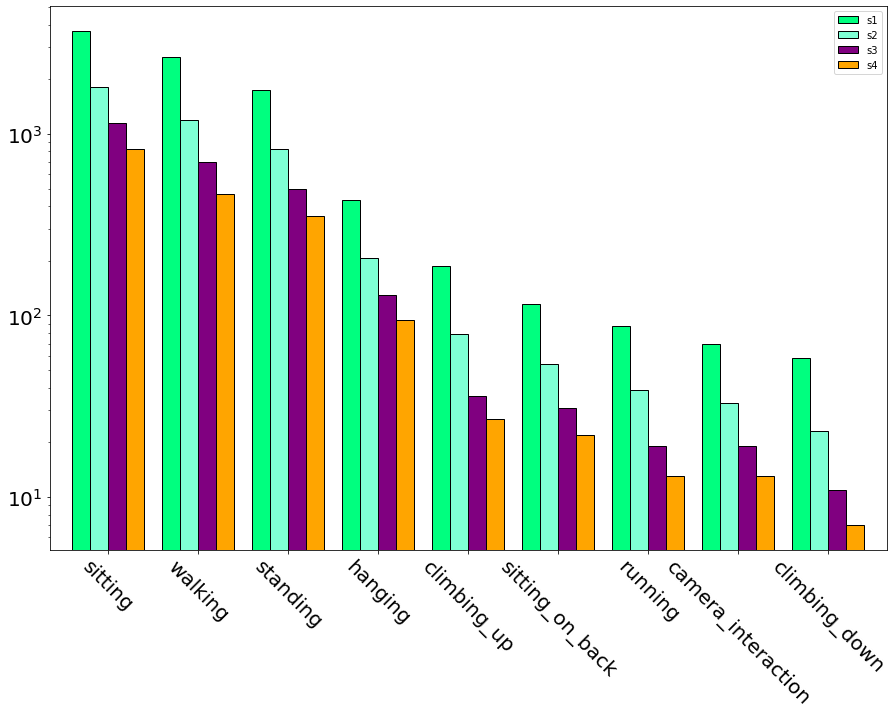

In [7]:
import pandas as pd

pd.DataFrame(sample_itvl_dict).plot(
    kind="bar",
    logy=True,
    figsize=(15, 10),
    width=0.8,
    edgecolor="black",
    color=["springgreen", "aquamarine", "purple", "orange"],
    rot=-45,
    fontsize=20,
)

# ax.figure.savefig("p500_small_medium_large.pdf", dpi=300, bbox_inches="tight")

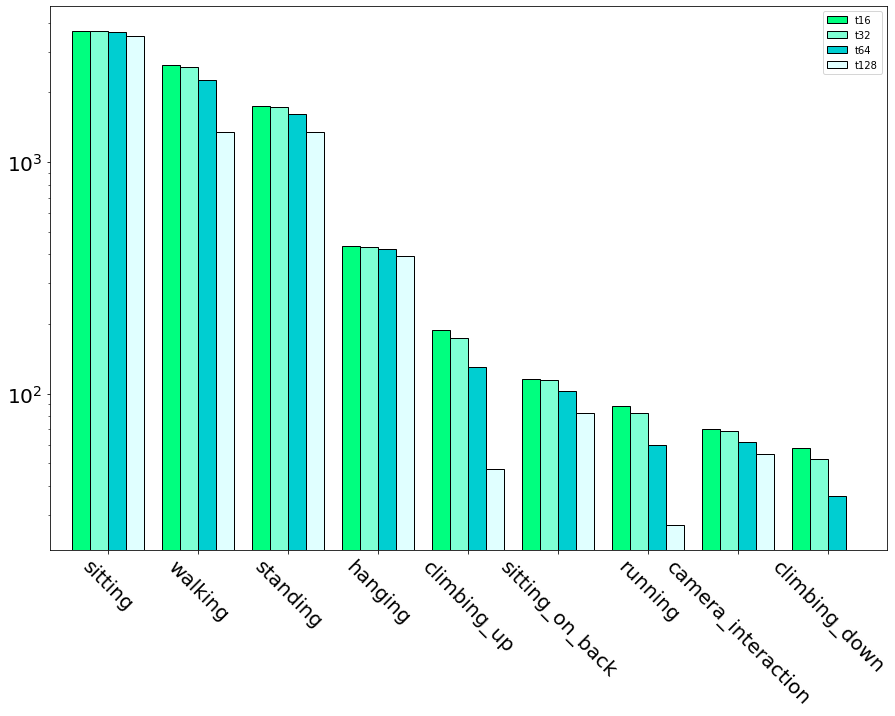

In [13]:
import pandas as pd

ax = pd.DataFrame(threshold_dict).plot(
    kind="bar",
    logy=True,
    figsize=(15, 10),
    width=0.8,
    edgecolor="black",
    color=["springgreen", "aquamarine", "darkturquoise", "lightcyan"],
    rot=-45,
    fontsize=20,
)

ax.figure.savefig("p500_thresh_dist.pdf", dpi=300, bbox_inches="tight")

In [28]:
pd.DataFrame(threshold_dict)

,t16,t32,t64,t128
sitting,3686,3677,3652,3496.0
walking,2639,2569,2262,1351.0
standing,1754,1724,1610,1345.0
hanging,434,430,420,391.0
climbing_up,188,173,130,47.0
sitting_on_back,115,114,103,82.0
running,88,82,60,27.0
camera_interaction,70,69,62,55.0
climbing_down,58,52,36,NaN


In [29]:
threshold_dict

{'t16': {'sitting': 3686,
  'walking': 2639,
  'standing': 1754,
  'hanging': 434,
  'climbing_up': 188,
  'sitting_on_back': 115,
  'running': 88,
  'camera_interaction': 70,
  'climbing_down': 58},
 't32': {'sitting': 3677,
  'walking': 2569,
  'standing': 1724,
  'hanging': 430,
  'climbing_up': 173,
  'sitting_on_back': 114,
  'running': 82,
  'camera_interaction': 69,
  'climbing_down': 52},
 't64': {'sitting': 3652,
  'walking': 2262,
  'standing': 1610,
  'hanging': 420,
  'climbing_up': 130,
  'sitting_on_back': 103,
  'camera_interaction': 62,
  'running': 60,
  'climbing_down': 36},
 't128': {'sitting': 3496,
  'walking': 1351,
  'standing': 1345,
  'hanging': 391,
  'sitting_on_back': 82,
  'camera_interaction': 55,
  'climbing_up': 47,
  'running': 27}}

**Number of apes per video**

In [ ]:
videos, apes_per_video = [], []
for video in df.video.unique():
    apes_per_video.append(len(df[df.video == video].ape_id.unique()))
    videos.append(video)
num_apes_per_video = pd.DataFrame({"video": videos, "apes_per_video": apes_per_video})

In [ ]:
print("Mean apes per video: ", num_apes_per_video.apes_per_video.mean())
print("Mode apes per video: ", num_apes_per_video.apes_per_video.mode()[0])

print("\nMaximum number of apes per video: ", num_apes_per_video.apes_per_video.max())
print("Min number of apes per video: ", num_apes_per_video.apes_per_video.min())

In [ ]:
# Videos with too high behaviour counts; Rx8tC9AIfs, atQUtTKhMJ, pbMMPocj0m

**Find annotation errors: duplicate ape_ids**

In [ ]:
for file in file_paths:
    f = open_json(file)
    ape_ids = get_ape_ids(f)
    current_df = get_flat_df(f)
    for ape in current_df.ape_id.unique():
        frame_list = current_df[current_df.ape_id == ape].frame_idx.values.tolist()
        frames = list(set([x for x in frame_list if frame_list.count(x) > 1]))
        if frames:
            print(file, ape, frames)